<a href="https://colab.research.google.com/github/the-bucketless/iihf/blob/main/iihf_api_shots_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IIHF API Shots Example

This notebook provides an example of how to scrape shots data from the IIHF API.

In [1]:
!pip install hockey-rink -q

  Preparing metadata (setup.py) ... done


In [2]:
from hockey_rink import IIHFRink
import json
import numpy as np
import pandas as pd
import requests

## Shots Data

Enter a URL for a game to be scraped. The API uses a different game ID than the URL does. The easiest way to find this ID is by viewing the source code for one of the game's pages (such as the play-by-play page) and searching for "data-game-id". That is, essentially, what the code below is attempting.

In [3]:
url = "https://www.iihf.com/en/events/2024/ww/gamecenter/playbyplay/55447/2-fin-vs-cze" #@param {type: "string"}

In [4]:
response = requests.get(url)

identifier = 'data-game-id="'
start_idx = response.text.find(identifier)
game_id = response.text[start_idx + len(identifier):]
game_id = int(game_id[:game_id.find('"')])

api_url = f"https://realtime.iihf.com/gamestate/GetLatestState/{game_id}"
api_response = requests.get(api_url)
api_json = json.loads(api_response.text)

The shots for a period are found in the "IceRingActions" data that comes from each of the values from the "Periods" key in the JSON. We'll join each period into a single dataframe.

In [5]:
def get_period_df(period, period_json):
    if not period_json["IceRingActions"]:
        return pd.DataFrame()

    return (
        pd.json_normalize(period_json["IceRingActions"])

        # Avoid having periods in column titles.
        .rename(columns=lambda x: x.replace(".", "_"))

        # Create columns to store the period and game ID.
        .assign(
            Period=period,
            GameId=game_id,
        )

        # All columns are read as strings - convert to more appropriate types.
        .astype({
            "Id": int,
            "IsExecutedByHomeTeam": bool,
            "ShowExecutedByDot": bool,
            "Coordinates_X": float,
            "Coordinates_Y": float,
            "Athlete_IH_Athlete_Id": int,
            "Athlete_Number": int,
        })
    )

In [6]:
# Join each period into a single dataframe.
shots = pd.concat(
    [
        get_period_df(period, period_json)
        for period, period_json in enumerate(api_json["Periods"], start=1)
    ],
    ignore_index=True,
)

The x and y-coordinates are stored as values from 0 to 1.

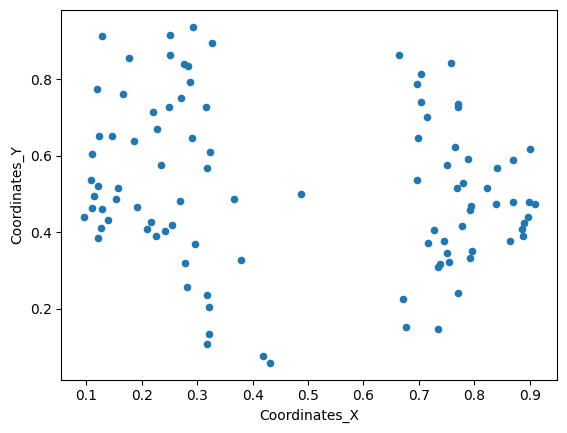

In [7]:
shots.plot("Coordinates_X", "Coordinates_Y", kind="scatter");

Let's convert those to something more useful for plotting. We'll multiply the coordinates to an appropriate size based on the rink and then shift everything over so that (0,0) is center ice.  

We'll also adjust coordinates so that the net is always to the positive side of the rink. This can be accomplished by multiplying the coordinates by the sign (+1 or -1) of the median x-coordinate for a team's shots in a period. The only time this won't work is if a team takes most of their shots from the wrong side of center.  

One thing that may bear mentioning is that the IIHF y-coordinates go from top-to-bottom rather than bottom-to-top, as is more conventional when plotting. We'll flip that around.  

The 2024 Women's Worlds is being played in Adirondack Bank Center which is an NHL-regulation sized rink. However, the images used by the IIHF are sized, unsurpisingly, based on the IIHF standard. To better match those images, the default will be to use IIHF dimensions.  

In [8]:
rink_length = 200  #@param {type: "number"}
rink_width = 100  #@param {type: "number"}

In [9]:
shots = (
    shots

    # Rescale coordinates.
    .assign(
        x=lambda df_: df_.Coordinates_X * rink_length - rink_length / 2,
        y=lambda df_: rink_width / 2 - df_.Coordinates_Y * rink_width,
    )

    # Shift all coordinates so net is on positive side of rink.
    .assign(
        x_side=lambda df_: np.sign(
            df_
            .groupby(["GameId", "Period", "IsExecutedByHomeTeam"])
            .x
            .transform("median")
        )
    )
    .assign(
        adj_x=lambda df_: df_.x * df_.x_side,
        adj_y=lambda df_: df_.y * df_.x_side,
    )
)

Now, we can see how this looks on a rink. With the coordinates as they are, things will get rather cluttered on the right side. So we'll flip the away team's shots to have them shooting to the left.

In [10]:
colors = {
    False: (0.92, 0.38, 0.14),    # Away team shots in orange.
    True: (0.32, 0.16, 0.53),    # Home team shots in purple.
}

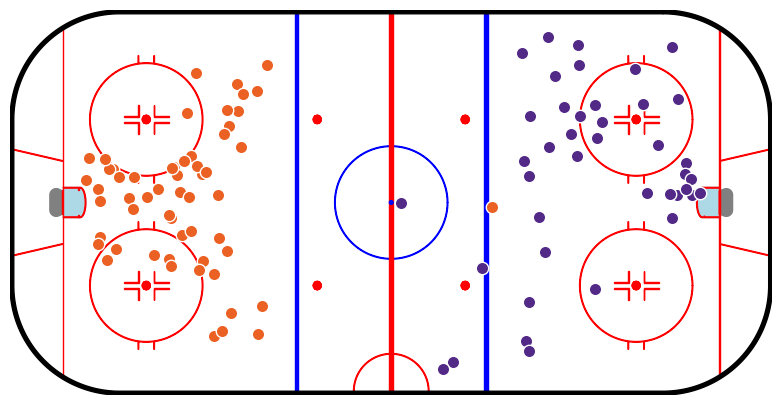

In [11]:
rink = IIHFRink(boards={"length": rink_length, "width": rink_width})

for is_home, team_shots in shots.groupby("IsExecutedByHomeTeam"):
    team_side = is_home * 2 - 1
    rink.scatter(
        team_shots.adj_x * team_side, team_shots.adj_y * team_side,
        color=colors[is_home],
        edgecolor="white", s=80,
        draw_kw={"figsize": (10, 5)}
    )